In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style('whitegrid')

In [3]:
%matplotlib inline

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
df = train_df.copy()

## Head of dataset

In [6]:
train_df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## descriptive statistics

In [8]:
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Loan_ID column is not important for us therefor, we will drop this column from both the dataset.

In [9]:
train_df.drop('Loan_ID', axis=1, inplace=True)

### one hot encoding

In [10]:
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        train_df[i] = pd.Categorical(train_df[i]).codes

### Checking missing values

In [11]:
for i in train_df.columns:
    if train_df[i].isnull().sum() != 0:
        print("Missing values is present in {0}".format(i))

Missing values is present in LoanAmount
Missing values is present in Loan_Amount_Term
Missing values is present in Credit_History


### filling missing values

In [12]:
for i in train_df.columns:
    if train_df[i].isnull().sum() != 0:
        train_df[i].fillna(train_df[i].median(), inplace=True)

### checking for outliers

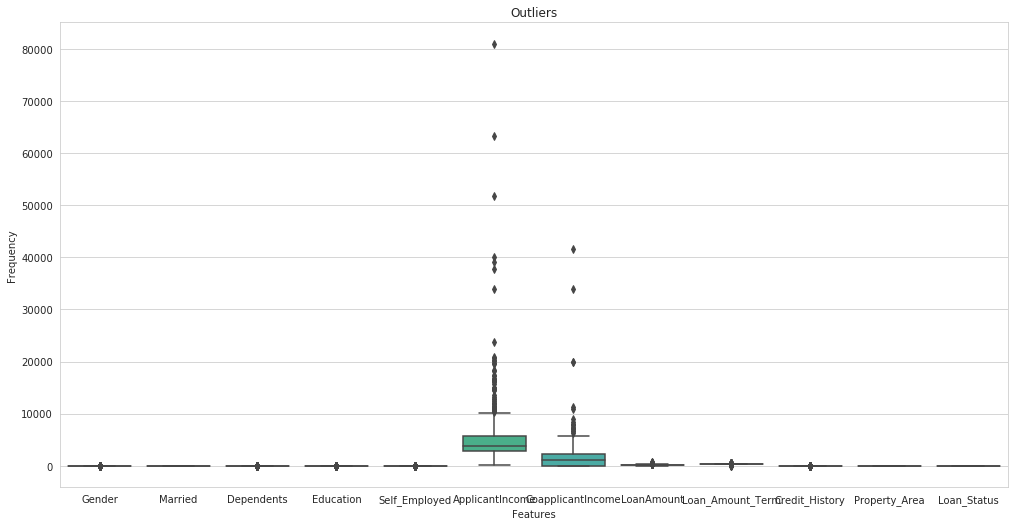

In [13]:
plt.figure(figsize=(14,7));
sns.boxplot(data = train_df);
plt.tight_layout();
plt.title('Outliers');
plt.xlabel('Features');
plt.ylabel('Frequency');

### Removing Outliers

In [14]:
def remove_outliers(df):
    Q1 = np.quantile(df, 0.25)
    Q3 = np.quantile(df, 0.75)
    IQR = Q3 - Q1
    ul, ll = Q3 + 1.5 * IQR, Q1 - 1.5 * IQR
    return ul, ll

In [15]:
for i in train_df.columns:
    ul, ll = remove_outliers(train_df[i])
    train_df[i] = np.where(train_df[i] > ul, ul, train_df[i])
    train_df[i] = np.where(train_df[i] < ll, ll, train_df[i])    

### checking for outliers

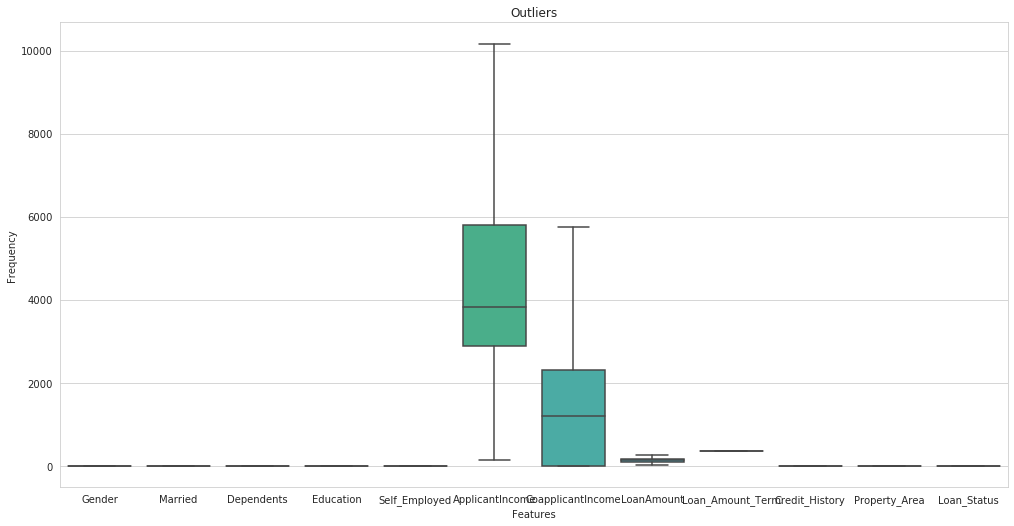

In [16]:
plt.figure(figsize=(14,7));
sns.boxplot(data = train_df);
plt.tight_layout();
plt.title('Outliers');
plt.xlabel('Features');
plt.ylabel('Frequency');

#### Since, outliers are not present in the dataset but the dataset looks unscaled therefore, we have to scaled the dataset.

### Scaling dataset

In [17]:
scalar = StandardScaler()
train_df = scalar.fit_transform(train_df)

### checking for scaled data

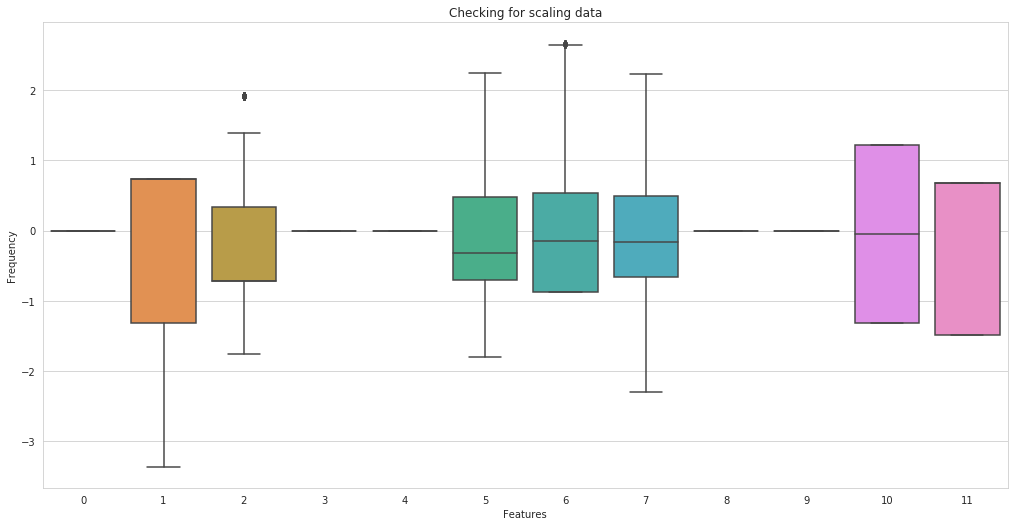

In [18]:
plt.figure(figsize=(14,7));
sns.boxplot(data = train_df);
plt.tight_layout();
plt.title('Checking for scaling data');
plt.xlabel('Features');
plt.ylabel('Frequency');

In [19]:
df.duplicated().sum()

0

# EDA

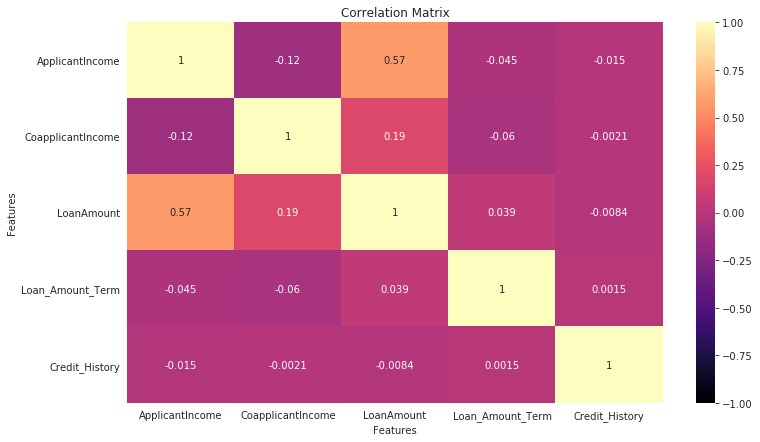

In [20]:
plt.figure(figsize=(12,7));
plt.title('Correlation Matrix');
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='magma');
plt.xlabel('Features');
plt.ylabel('Features');

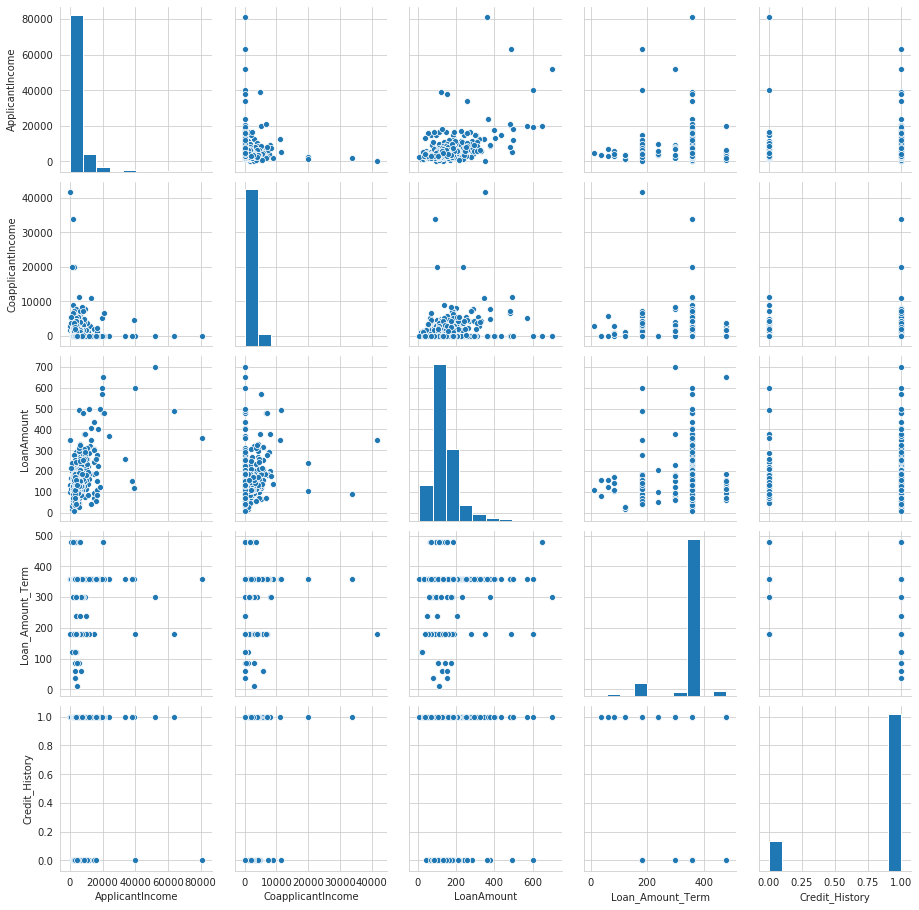

In [21]:
sns.pairplot(df);

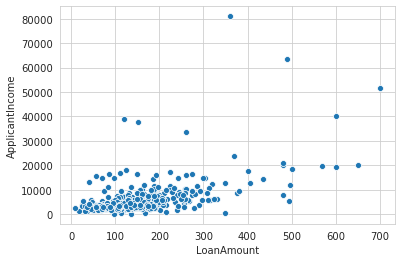

In [22]:
sns.scatterplot(df['LoanAmount'], df['ApplicantIncome']);

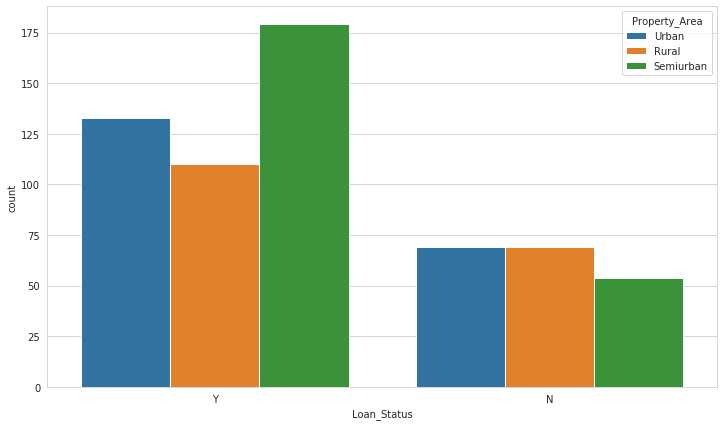

In [23]:
plt.figure(figsize=(12,7));
sns.countplot(df['Loan_Status'], hue=df['Property_Area']);

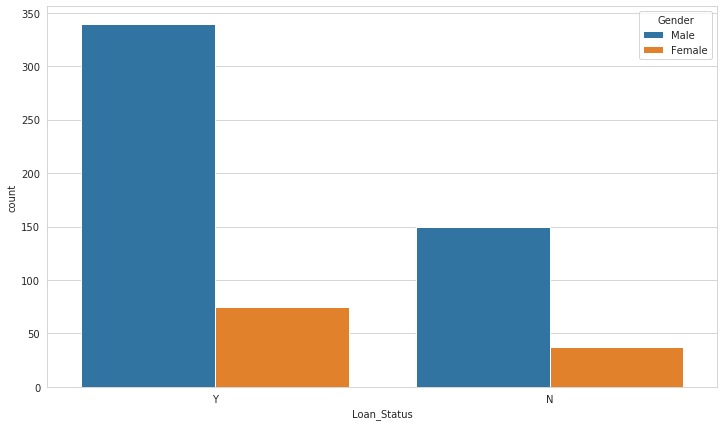

In [24]:
plt.figure(figsize=(12,7));
sns.countplot(df['Loan_Status'], hue=df['Gender']);

# Model building